In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import scanpy as sc
import scipy as sp

import sys
import os
sys.path.append(os.path.abspath("./utility_functions"))

import rz_functions as rz
import ng_functions as ng
import rz_utility_spring as srz

from time import time
from seaborn import heatmap

import scrublet as scr


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


python version: 3.6.10


In [30]:
cluster_annotation_dict =      {'0' : 'N1',
                                '1' : 'CM',
                                '2' : 'Mac1',
                                '3' : 'DC1',
                                '4' : 'N2',
                                '5' : 'DC2',
                                '6' : 'Th1',
                              '6,5' : 'Th17',
                             '6,17' : 'Tmix',
                             '6,31' : 'T8',
                                '7' : 'B1',
                                '8' : 'EC1',
                                '9' : 'DC3',
                               '10' : 'KC',
                               '11' : 'NK',
                               '12' : 'Mac2',
                               '13' : 'B2',
                               '14' : 'NKT',
                               '15' : 'N3',
                               '16' : 'NCM',
                               '17' : 'DC4',
                               '18' : 'pDC',
                               '19' : 'Treg',
                               '20' : 'N4',
                               '21' : 'N5',
                               '22' : 'EC2',
                               '23' : 'MonoDC', #placeholder
                               '24' : 'Basophils',
                               '25' : 'B3',
                               '26' : 'RBC',
                               '27' : 'Hepatocytes'}


coarse_annotation_dict =        {'B1' : 'B cells',
                                 'B2' : 'B cells',
                                 'B3' : 'B cells',
                                 'Basophils' : 'Basophils',
                                 'DC1' : 'MoMacDC',
                                 'DC2' : 'MoMacDC',
                                 'DC3' : 'MoMacDC',
                                 'DC4' : 'MoMacDC',
                                 'Mac1' : 'MoMacDC',
                                 'Mac2' : 'MoMacDC',
                                 'Mac3' : 'MoMacDC',
                                 'Mac4' : 'MoMacDC',
                                 'CM' : 'MoMacDC',
                                 'NCM' : 'MoMacDC',
                                 'MonoDC' : 'MoMacDC',
                                 'KC' : 'MoMacDC',
                                 'N1' : 'Neutrophils',
                                 'N2' : 'Neutrophils',
                                 'N3' : 'Neutrophils',
                                 'N4' : 'Neutrophils',
                                 'N5' : 'Neutrophils',
                                 'N6' : 'Neutrophils',
                                 'NK' : 'NK cells',
                                 'Th1' : 'T cells',
                                 'Th17' : 'T cells',
                                 'Tmix' : 'T cells',
                                 'T8' : 'T cells',
                                 'Treg' : 'T cells',
                                 'pDC' : 'pDC',
                                 'Hepatocytes' : 'Hepatocytes',
                                 'EC1' : 'Endothelial cells',
                                 'EC2' : 'Endothelial cells',
                                 'RBC' : 'Red blood cells'}

# Data loading, preprocessing and normalization

In [5]:
adata = sc.read_h5ad('backups/tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200425_16h46.h5ad')

adata[:,['Il12b']].X = adata[:,['Il12b', 'eYFP']].X.sum(1)
adata[:,['eYFP']].X = 0


sc.pp.normalize_total(adata, target_sum=1e4)

adata.obs['n_counts'] = adata.X.sum(1).A1

sc.tl.leiden(adata, resolution = 1, restrict_to = ('leiden', ['6']), key_added = 'T_cell_subclusters')


# if cell is on cluster 6 (Leiden lvl 1), split cluster 6 into "6,16"; "6,17" (Leiden lvl 2), and "6,5" (T cell subclustering)

adata.obs.leiden = np.where(adata.obs.leiden2.isin(['16', '17', '31']), np.where(adata.obs.leiden2.isin(['17', '31']), ('6,'+adata.obs.leiden2.astype(str)).astype('category'),
                                                                      np.where(adata.obs.T_cell_subclusters == '6,5', '6,5', adata.obs.leiden)), #np.where(adata.obs.T_cell_subclusters == '6,5', '6,5', ('6,'+adata.obs.leiden2.astype(str)).astype('category')),
                                                                      adata.obs.leiden)


adata.obs.head()


,barcode,group,library_name,marker,max_mt,min_tot,mito_frac,n_counts,n_genes,pool,tissue,treatment,leiden,leiden2,leiden3,leiden4,doublet_score,predicted_doublet,T_cell_subclusters
48-pool1,AAACAAACAGAGGATAAGACACCA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.040964,9999.998047,348,pool1,Liver,NT,8,7,5,2,0.007103,False,8
98-pool1,AAACAAACAGAGGATACAATACTT,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.005613,10000.000000,581,pool1,Liver,NT,20,32,37,45,0.014590,False,20
237-pool1,AAACAAACAGAGGATAGGCCCTTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035451,9999.998047,470,pool1,Liver,NT,11,14,20,24,0.016036,False,11
246-pool1,AAACAAACAGAGGATAGGGAGGTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.018000,10000.000000,374,pool1,Liver,NT,16,24,27,50,0.027342,False,16
342-pool1,AAACAAACAGAGGATATGGCTACC,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035088,10000.000000,318,pool1,Liver,NT,"6,17",17,16,12,0.007778,False,"6,0"


In [6]:
#loglikelihoods = sp.sparse.load_npz('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz')
logls = np.load('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz', allow_pickle=True)

mostlikely_subset = pd.DataFrame(logls['data'], index=logls['index'], columns=logls['columns']).idxmax()
mostlikely_subset = pd.Series(mostlikely_subset, dtype='category')
mostlikely_subset.index = adata.obs.index

mostlikely_celltype = mostlikely_subset.map(ng.cell_subset_dict).astype('category')

In [7]:
adata.obs['cell_type'] = mostlikely_celltype
adata.obs['minor_subset'] = mostlikely_subset

#annotate color palette in adata.uns
adata.uns['cell_type_colors'] = adata.obs['cell_type'].cat.categories.map(ng.cell_type_cmap).tolist()
adata.uns['minor_subset_colors'] = adata.obs['minor_subset'].cat.categories.map(ng.cell_subset_cmap).tolist()

In [8]:
adata = adata[~(adata.obs.predicted_doublet)]
adata = adata[~adata.obs['leiden'].isin(['28','29','30'])]

adata.obs['leiden_minor_subset'] = adata.obs.leiden.map(cluster_annotation_dict).astype('category')
adata.obs['leiden_cell_type'] = adata.obs.leiden_minor_subset.map(coarse_annotation_dict).astype('category')


Trying to set attribute `.obs` of view, copying.


... storing 'leiden' as categorical


[<Figure size 2061x400 with 3 Axes>]

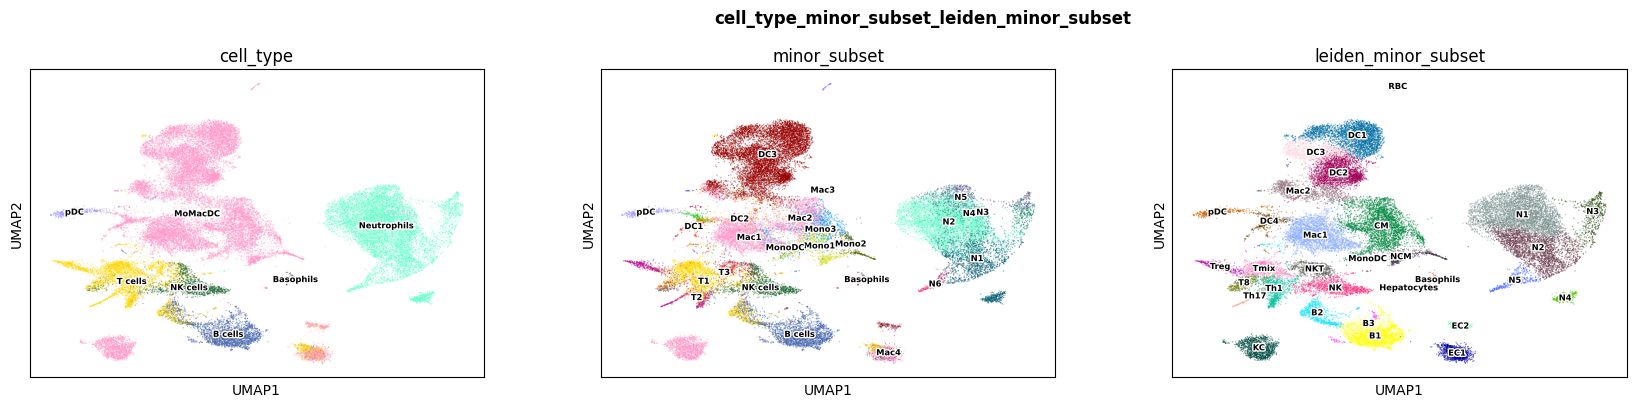

In [9]:
ng.umap_plot(adata, color=['cell_type', 'minor_subset', 'leiden_minor_subset'], return_fig=True, save_fig=False, alpha=0.5)

# RZ cluster characterization

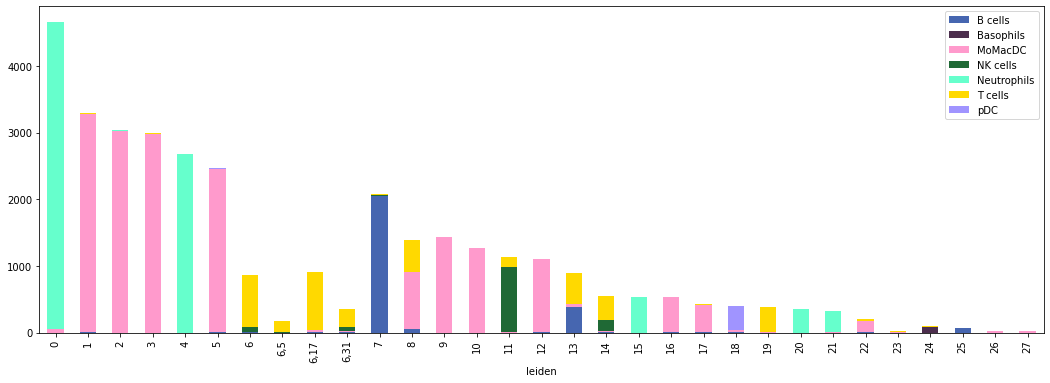

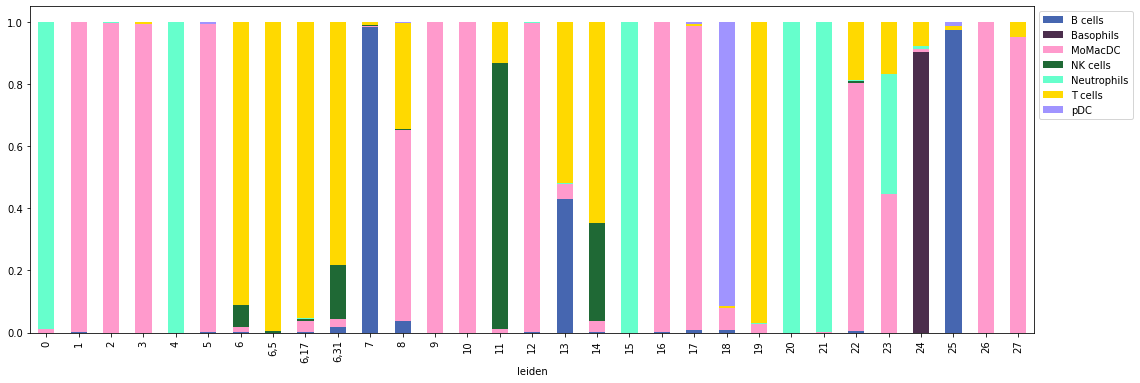

In [10]:
leiden_cell_type_counts = adata.obs.groupby('leiden').cell_type.value_counts().to_frame(name='count').reset_index().pivot(index='leiden',columns='cell_type', values='count')
leiden_cell_type_percentages = leiden_cell_type_counts.div(leiden_cell_type_counts.sum(axis=1), axis=0)
#


leiden_cell_type_counts.plot.bar(width=0.5, stacked=True, color=ng.cell_type_cmap.values())
plt.gcf().set_size_inches(18,6)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

leiden_cell_type_percentages.plot.bar(width=0.5, stacked=True, color=ng.cell_type_cmap.values())
plt.gcf().set_size_inches(18,6)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

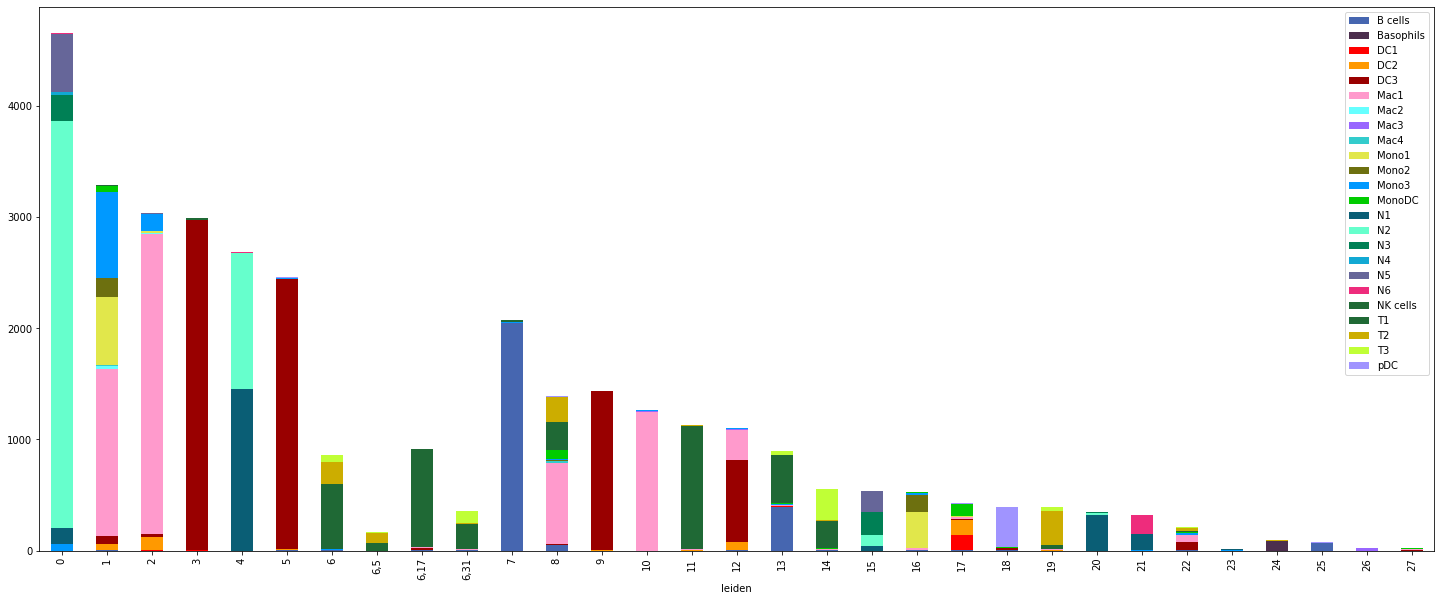

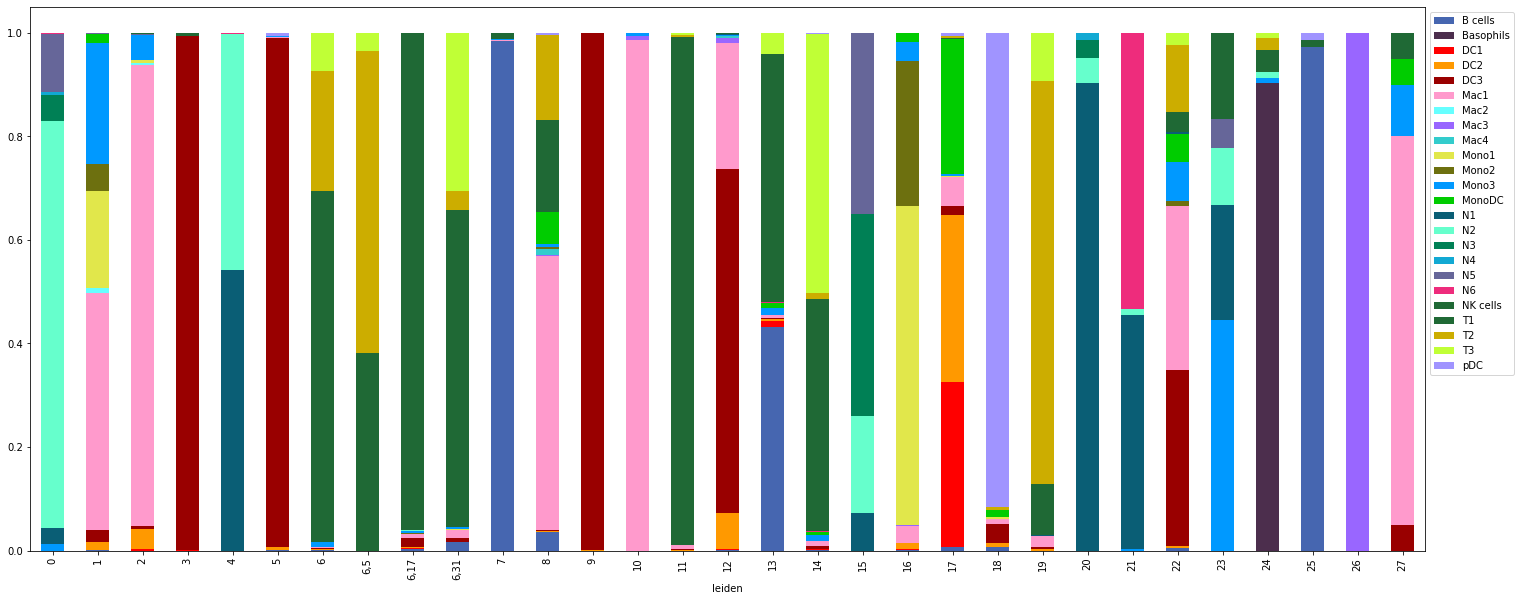

In [11]:
leiden_cell_subset_counts = adata.obs.groupby('leiden').minor_subset.value_counts().to_frame(name='count').reset_index().pivot(index='leiden',columns='minor_subset', values='count')
leiden_cell_subset_percentages = leiden_cell_subset_counts.div(leiden_cell_subset_counts.sum(axis=1), axis=0)

leiden_cell_subset_counts.plot.bar(width=0.5, stacked=True, color=ng.cell_subset_cmap.values())
plt.gcf().set_size_inches(25,10)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

leiden_cell_subset_percentages.plot.bar(width=0.5, stacked=True, color=ng.cell_subset_cmap.values())
plt.gcf().set_size_inches(25,10)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [13]:
cat0 = rz.centroids('leiden_minor_subset', adata).T
cat0.head()

,EC1,N4,NK,NCM,Tmix,DC1,N1,Th1,B1,KC,...,B2,EC2,B3,T8,Hepatocytes,DC2,Basophils,RBC,MonoDC,DC3
Xkr4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.332447,0.000000,0.000000,0.0,0.000000,0.000000
Rp1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Sox17,0.839071,0.000000,0.000000,0.000000,0.000000,0.000000,0.003524,0.020223,0.000000,0.000000,...,0.000000,0.428334,0.000000,0.054299,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Mrpl15,0.404065,0.000000,0.338068,0.461791,0.766301,0.548763,0.055832,0.469255,0.584114,0.245774,...,1.576470,0.784322,1.552626,0.638389,3.280503,0.495247,0.367278,0.0,0.308471,0.341070
Lypla1,0.699091,0.250964,0.661918,0.576946,0.471754,0.592256,0.301729,0.663049,0.362715,0.351326,...,0.512409,0.580516,0.934806,0.761356,0.679124,0.685232,0.891293,0.0,2.336199,0.462151


In [14]:
pseudo = 0.1
cat = cat0 + pseudo

# Load reference expression profiles in an AnnData object compatible with scanpy¶

In [15]:
prepath = 'Zilionis_Immunity_2019/'
# load count data
rzdata = sc.read_mtx(prepath+'GSE127465_mouse_counts_normalized_15939x28205.mtx.gz')

# load cell annotations
rzdata.obs = pd.read_csv(prepath+'GSE127465_mouse_cell_metadata_15939x12.tsv.gz',
            sep='\t',comment='#')

# load gene names
rzdata.var_names = np.loadtxt(prepath+'GSE127465_gene_names_mouse_28205.tsv.gz',dtype=str)
rzdata.var_names_make_unique()

#normalize immunity paper data to 10,000 counts per cell
sc.pp.normalize_per_cell(rzdata,counts_per_cell_after=1e4)

print(rzdata.shape)
rzdata.obs.head()

Transforming to str index.


(15939, 28205)


,Tumor or healthy,Biological replicate,Library,Barcode,Library prep batch,Total counts,Percent counts from mitochondrial genes,Most likely Immgen cell type,Major cell type,Minor subset,x,y,n_counts
0,t,Tumor-bearing 1,t_1_1,bc0001,round1_20151128,7927.0,3.393,MF_Thio5_II+480int_PC,MoMacDC,Mac1,1174.120533,-217.075559,2434.620605
1,t,Tumor-bearing 1,t_1_1,bc0002,round1_20151128,5665.0,6.461,DC_103-11b+24+_Lu,MoMacDC,DC1,1068.808968,-37.966851,2434.620361
2,t,Tumor-bearing 1,t_1_1,bc0003,round1_20151128,4615.0,2.579,DC_8-4-11b+_SLN,MoMacDC,DC3,791.206113,-51.756695,2434.620117
3,t,Tumor-bearing 1,t_1_1,bc0004,round1_20151128,5353.0,3.082,DC_8+_Th,MoMacDC,DC1,1068.688851,-17.459386,2434.620361
4,t,Tumor-bearing 1,t_1_1,bc0005,round1_20151128,4653.0,2.901,DC_8-4-11b+_SLN,MoMacDC,DC3,805.516538,-52.706709,2434.620117


# Find common genes between the two datasets.
 Filtering on variable genes is also a possibility but I start by simply using all genes

In [16]:
Eraw = rzdata.X
print(type(Eraw))

gene_list = rzdata.var_names

<class 'scipy.sparse.csr.csr_matrix'>


In [17]:
# common genes
gmask = np.in1d(gene_list, cat.index)

# genes detected in the current dataset:
m2 = np.array(Eraw.sum(axis=0))[0]>0

# combine masks
gmask = gmask&m2


common_genes = gene_list[gmask]
print(len(gene_list),len(cat.index),len(common_genes))

28205 22631 20075


In [18]:
print(Eraw.shape)

(15939, 28205)


In [19]:
start = time()
bays = []
i = 0
step=5000
comment = 'zilionis_classified_on_leiden_clusters'
for j in range(step,Eraw.shape[0]+step,step):
    
    # Eraw - sparse cells x gene matrix
    j = min(j,Eraw.shape[0])
    tmp_dense = pd.DataFrame(Eraw.T[gmask][:,i:j].todense())
    tmp_dense.index = np.array(gene_list)[gmask]
    
    bay = rz.bayesian_classifier(tmp_dense,cat.loc[common_genes])
    bays.append(bay)
    i0 = i
    i = j
    
    print('%.2f min.'%((time()-start)/60.))
    print('cells from %d to %d done'%(i0,j))

# conenate
bay = pd.concat(bays,axis=1)

# reset index
bay.columns = np.arange(bay.shape[1])

fname = 'backups/loglikelihoods_bay_classif_%s_%s'%(comment,rz.now())
print(fname)
rz.save_df(bay,fname)

1.66 min.
cells from 0 to 5000 done
3.32 min.
cells from 5000 to 10000 done
4.98 min.
cells from 10000 to 15000 done
5.29 min.
cells from 15000 to 15939 done
backups/loglikelihoods_bay_classif_zilionis_classified_on_leiden_clusters_200426_02h36


# Load classifier log-likelihoods, distinguish from Lung --> Tox

In [20]:
logls_lung = np.load('backups/loglikelihoods_bay_classif_zilionis_classified_on_leiden_clusters_200421_05h06.npz', allow_pickle=True)

mostlikely_subset_lung = pd.DataFrame(logls_lung['data'], index=logls_lung['index'], columns=logls_lung['columns']).idxmax()
mostlikely_subset_lung = pd.Series(mostlikely_subset_lung, dtype='category')
mostlikely_subset_lung.index = rzdata.obs.index

mostlikely_celltype_lung = mostlikely_subset_lung.map(coarse_annotation_dict).astype('category')

rzdata.obs['leiden_cell_type'] = mostlikely_celltype_lung
rzdata.obs['leiden_minor_subset'] = mostlikely_subset_lung

In [21]:
rzdata.obs.leiden_cell_type.cat.categories

#np.where(rzdata.obs.leiden_minor_subset.map(coarse_annotation_dict).astype('category').isna())
#rzdata.obs.iloc[[ 305, 4746, 9669, 9820, 9842, 9863],:]

Index(['B cells', 'Basophils', 'Endothelial cells', 'MoMacDC', 'Neutrophils',
       'T cells', 'pDC'],
      dtype='object')

# Major cell type level

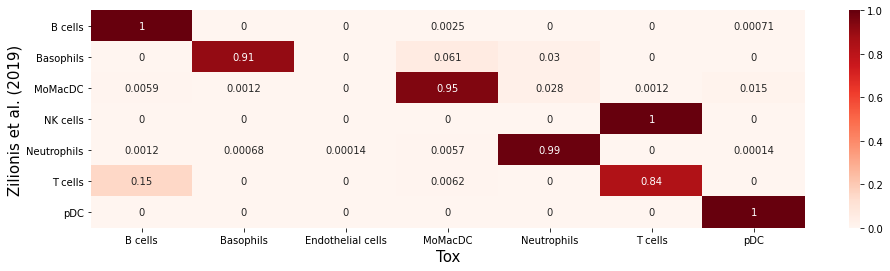

In [22]:
rz_to_tox_cell_type = rzdata.obs.groupby(['Major cell type', 'leiden_cell_type']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(index='Major cell type', columns='leiden_cell_type')
rz_to_tox_cell_type.columns = rz_to_tox_cell_type.columns.get_level_values('leiden_cell_type')


plt.figure(figsize=(16,4))
heatmap(rz_to_tox_cell_type, annot=True, cmap='Reds')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
#plt.xticks(rotation=45)


plt.show()

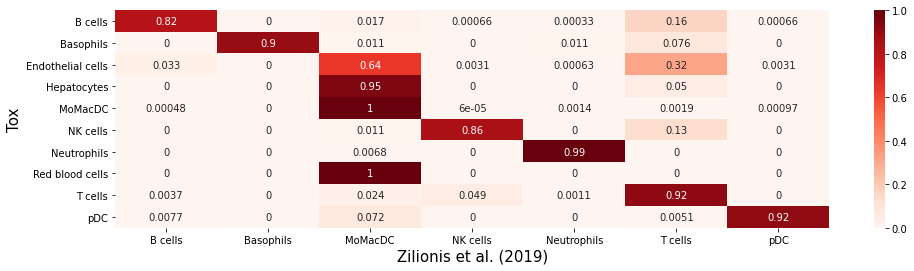

In [23]:
tox_to_rz_cell_type = adata.obs.groupby(['leiden_cell_type', 'cell_type']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(columns='leiden_cell_type', index='cell_type')
tox_to_rz_cell_type.columns = tox_to_rz_cell_type.columns.get_level_values('leiden_cell_type')


plt.figure(figsize=(16,4))

#transpose to keep direction of axes and still make it multiplicable
heatmap(tox_to_rz_cell_type.transpose(), annot=True, cmap='Reds')

plt.xlabel('Zilionis et al. (2019)', fontsize=15)
plt.ylabel('Tox', fontsize=15)

plt.show()

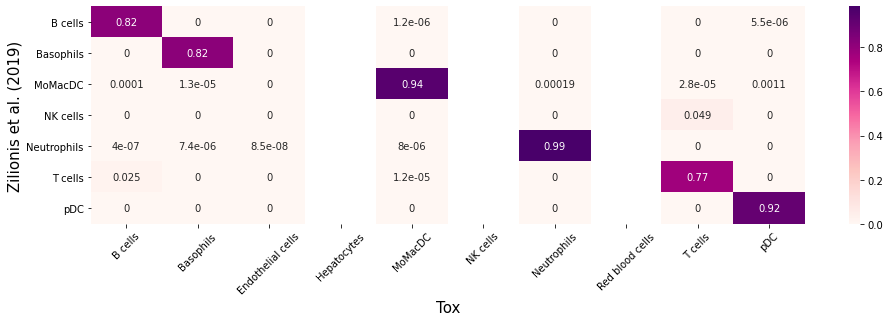

In [24]:
reciprocal_cell_type = rz_to_tox_cell_type * tox_to_rz_cell_type

plt.figure(figsize=(16,4))
heatmap(reciprocal_cell_type, annot=True, cmap='RdPu')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
plt.xticks(rotation=45)

plt.show()

# Minor subset level

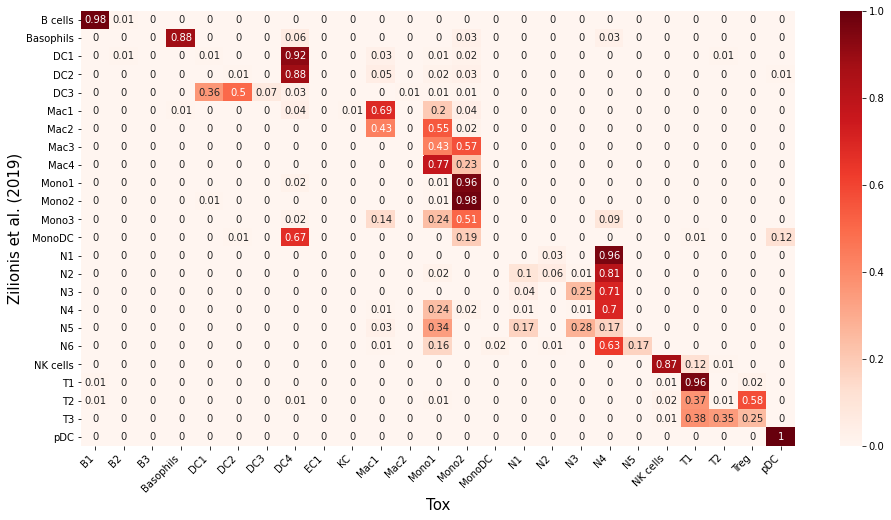

In [25]:
rz_to_tox_subset = rzdata.obs.groupby(['Minor subset', 'leiden_minor_subset']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(index='Minor subset', columns='leiden_minor_subset')
rz_to_tox_subset.columns = rz_to_tox_subset.columns.get_level_values('leiden_minor_subset')

plt.figure(figsize=(16,8))
heatmap(round(rz_to_tox_subset,2), annot=True, cmap='Reds')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
plt.xticks(rotation=45, horizontalalignment="right")

plt.show()

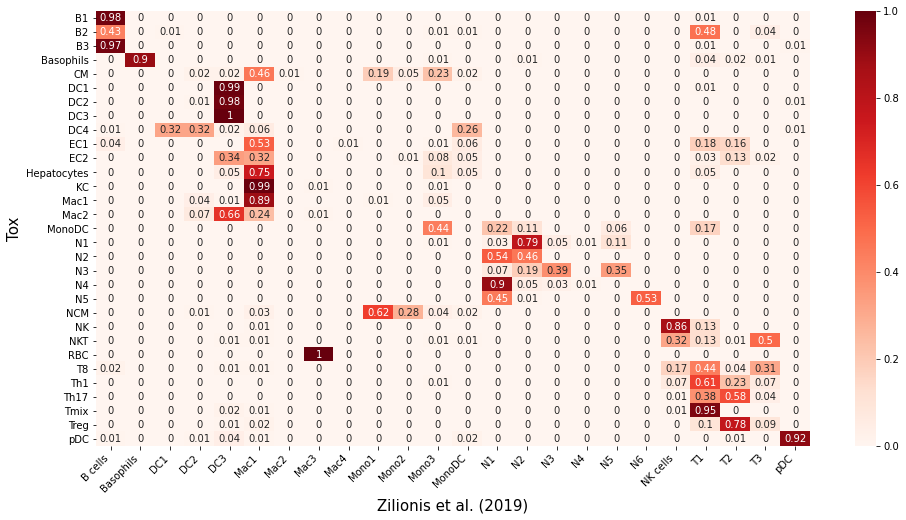

In [26]:
tox_to_rz_subset = adata.obs.groupby(['leiden_minor_subset', 'minor_subset']).size().groupby(level=0).apply(lambda x : x/sum(x)).reset_index(name='fraction').pivot(columns='leiden_minor_subset', index='minor_subset')
tox_to_rz_subset.columns = tox_to_rz_subset.columns.get_level_values('leiden_minor_subset')
tox_to_rz_subset = tox_to_rz_subset[sorted(tox_to_rz_subset)]


#tox_to_rz_subset.index.get_level_values('leiden_minor_subset')
plt.figure(figsize=(16,8))
heatmap(round(tox_to_rz_subset.transpose(),2), annot=True, cmap='Reds')

plt.xlabel('Zilionis et al. (2019)', fontsize=15)
plt.ylabel('Tox', fontsize=15)
plt.xticks(rotation=45, horizontalalignment="right")


plt.show()

#round(tox_to_rz_subset.transpose(),2).index.get_level_values('leiden_minor_subset')

In [27]:
tox_to_rz_subset.columns

CategoricalIndex(['B1', 'B2', 'B3', 'Basophils', 'CM', 'DC1', 'DC2', 'DC3',
                  'DC4', 'EC1', 'EC2', 'Hepatocytes', 'KC', 'Mac1', 'Mac2',
                  'MonoDC', 'N1', 'N2', 'N3', 'N4', 'N5', 'NCM', 'NK', 'NKT',
                  'RBC', 'T8', 'Th1', 'Th17', 'Tmix', 'Treg', 'pDC'],
                 categories=['B1', 'B2', 'B3', 'Basophils', 'CM', 'DC1', 'DC2', 'DC3', ...], ordered=False, name='leiden_minor_subset', dtype='category')

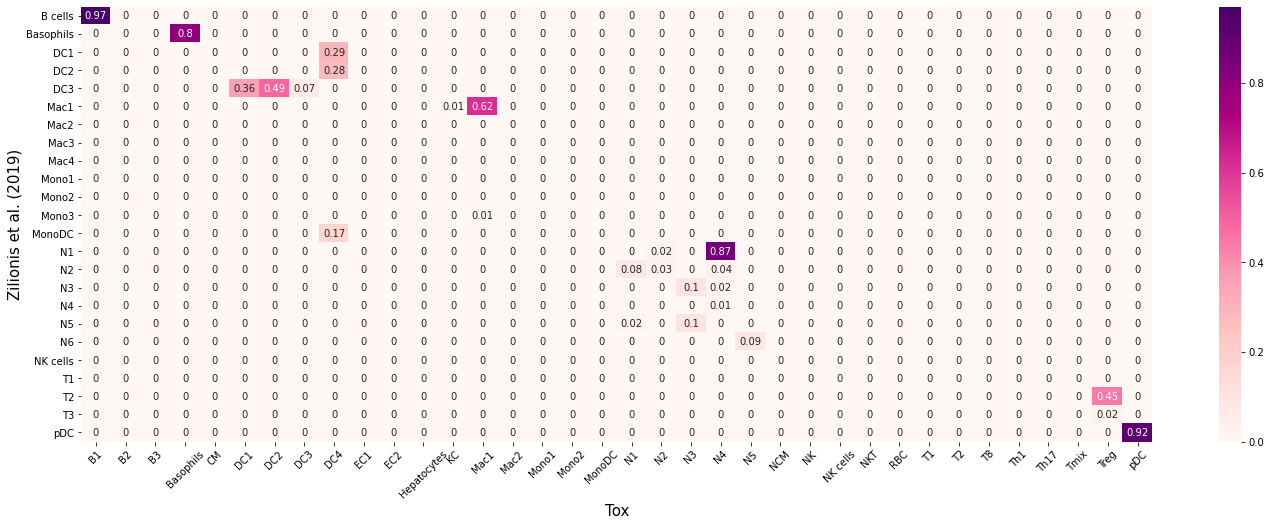

In [28]:
reciprocal_subset = rz_to_tox_subset * tox_to_rz_subset

plt.figure(figsize=(24,8))
heatmap(round(reciprocal_subset.fillna(0),2), annot=True, cmap='RdPu')

plt.ylabel('Zilionis et al. (2019)', fontsize=15)
plt.xlabel('Tox', fontsize=15)
plt.xticks(rotation=45)

plt.show()
